In [ ]:
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

### #1

In [107]:
x = np.array([[1.,1., 2.], [1.,-1.,1.]], dtype=np.float32)
y = np.array([0.5,0.], dtype=np.float32).reshape(2,1)

In [114]:
class perceptron:
    def __init__(self):
        self.w = tf.Variable(tf.random.normal([3, 1]))
        self.optimizer = tf.optimizers.SGD(learning_rate=0.1)
    
    def prediction(self, X):
        pred = tf.matmul(X, self.w)
        return tf.nn.relu(pred)
    
    def mse(self, pred, y):
        return tf.reduce_mean((pred - y)**2)
    
    def train(self, X, y):
        
        with tf.GradientTape() as t:
            pred = self.prediction(X)
            loss = self.mse(pred, y)
            
        g = t.gradient(loss, [self.w])
        self.optimizer.apply_gradients(zip(g, [self.w]))

In [144]:
p = perceptron()

for i in range(100):
    p.train(x, y)

In [145]:
# Проверка
tf.nn.relu(tf.matmul(x, p.w))

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[5.0000000e-01],
       [2.3841858e-07]], dtype=float32)>

### #2

In [146]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [147]:
X_train = X_train/255
X_test = X_test/255

In [148]:
X_train = X_train.reshape(X_train.shape[0], 28**2)
X_test = X_test.reshape(X_test.shape[0], 28**2)

In [149]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

In [150]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [151]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.shuffle(5000).batch(512)

In [152]:
from IPython import display

def visualize(l1,l2, h1, h2):
    plt.figure(figsize=(20,5)) 
    epo_range = range(1,len(h1)+1)
    tick_range = range(1,len(h1)+1,2)
    plt.subplot(1,2,1)
    plt.title('Learning loss')
    plt.plot(epo_range,l1, label='train set')
    plt.plot(epo_range,l2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.legend(title = 'Loss at:')
    
    plt.subplot(1,2,2)
    plt.title('Learning accuracy')
    plt.plot(epo_range,h1, label='train set')
    plt.plot(epo_range,h2, label='valid set')
    plt.grid()
    plt.xticks(tick_range)
    plt.ylim(0, 1.)
    plt.legend(title = 'Accuracy at:')
    
    display.clear_output(wait=True)
    plt.show()

In [157]:
class nn:
    def __init__(self, num_features, num_classes, n_hidden_neurons):
        self.num_features = num_features
        self.num_classes = num_classes
        self.n_hidden_neurons = n_hidden_neurons
        #self.w1 = tf.Variable(tf.random.normal([self.num_features, self.num_classes]), name='w1')
        self.w1 = tf.Variable(tf.random.normal([self.num_features, self.n_hidden_neurons]), name='w1')
        #self.b1 = tf.Variable(tf.random.normal([self.num_classes]), name='b1')
        self.b1 = tf.Variable(tf.random.normal([self.n_hidden_neurons]), name='b1')
        #self.w2 = tf.Variable(tf.random.normal([self.num_classes, self.num_classes]), name='w2')
        self.w2 = tf.Variable(tf.random.normal([self.n_hidden_neurons, self.num_classes]), name='w2')
        self.b2 = tf.Variable(tf.random.normal([self.num_classes]), name='b2')
        self.optimizer = tf.optimizers.Adam(0.01)
        
    def nn(self, X):
        hidden_neurons = tf.nn.relu(tf.matmul(X,self.w1)+self.b1)
        return tf.nn.softmax(tf.matmul(hidden_neurons,self.w2)+self.b2)
    
    def logloss(self, p_pred, y_true):
        p_pred = tf.clip_by_value(p_pred, 1e-9, 1.)
        return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(p_pred), axis=1))
    
    def accuracy(self, y_pred, y_true):
        correct_prediction = tf.equal(tf.argmax(y_pred,axis=1), tf.argmax(y_true,axis=1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        return tf.reduce_mean(correct_prediction)
    
    def model_train(self, X, Y):
        
        with tf.GradientTape() as g:
            p_pred = self.nn(X)
            logloss_value = self.logloss(p_pred, Y)
        gradients = g.gradient(logloss_value,[self.w1,self.b1, self.w2,self.b2])
        self.optimizer.apply_gradients(zip(gradients, [self.w1,self.b1, self.w2,self.b2]))

In [164]:
num_classes = 10
num_features = 784
n_hidden_neurons = 8

our_nn = nn(num_features, num_classes, n_hidden_neurons)

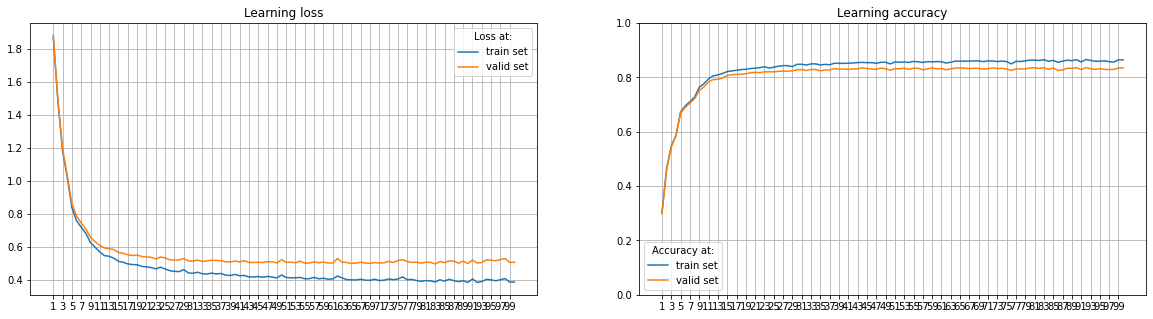

In [165]:
epochs = 100           # число эпох 
training_steps = 1000  # сколько раз на эпохе теребить генератор батчей

# Вектора для метрик
loss_test, loss_train  = [ ], [ ] 
acc_test, acc_train = [ ], [ ]

for i in range(epochs):
    
    # Проходимся по всем батчам
    for batch_x, batch_y in train_data.take(training_steps):
        
        # Делаем шаг градиентного спуска 
        our_nn.model_train(batch_x, batch_y)
    
    # в конце эпохи считаем метрики
    p_train = our_nn.nn(X_train)
    p_test = our_nn.nn(X_test)

    loss_train.append(our_nn.logloss(p_train, y_train))
    loss_test.append(our_nn.logloss(p_test, y_test))

    acc_train.append(our_nn.accuracy(p_train, y_train))
    acc_test.append(our_nn.accuracy(p_test, y_test))

    # визуализируем
    visualize(loss_train, loss_test, acc_train, acc_test) 